O objetivo deste projeto é predizer a partir de perguntas qual tag é relacionada à pergunta realizada. Para isto serão utilizados dados do Stack Overflow

In [3]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from ast import literal_eval

import nltk
from nltk.corpus import stopwords

import re

from collections import Counter

from itertools import chain

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score, recall_score

nltk.download('stopwords') # Para caso a lista esteja desatualizada

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
def read_data(uploadfile):

  # importando o arquivo
  data = pd.read_csv(uploadfile, sep='\t')

  #removendo as aspas que são importadas nos dados
  data['tags'] = data['tags'].apply(literal_eval)

  return data

In [5]:
train_set = read_data('/content/train.tsv')

validation_set = read_data('/content/validation.tsv')

In [6]:
train_set.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


In [7]:
validation_set.head()

,title,tags
0,Why odbc_exec always fail?,"[php, sql]"
1,Access a base classes variable from within a c...,[javascript]
2,"Content-Type ""application/json"" not required i...","[ruby-on-rails, ruby]"
3,Sessions in Sinatra: Used to Pass Variable,"[ruby, session]"
4,"Getting error - type ""json"" does not exist - i...","[ruby-on-rails, ruby, json]"


In [8]:
print(f"O conjunto de treinamento possui {train_set.shape[0]} linhas e {train_set.shape[1]} colunas")

O conjunto de treinamento possui 100000 linhas e 2 colunas


In [9]:
print(f"O conjunto de validação possui {validation_set.shape[0]} linhas e {validation_set.shape[1]} colunas")

O conjunto de validação possui 30000 linhas e 2 colunas


In [10]:
# Separando as features do conjunto de treino
X_train, y_train = train_set['title'].values, train_set['tags'].values

# Separando as features do conjunto de validação
X_val, y_val = validation_set['title'].values, validation_set['tags'].values

In [11]:
X_train

array(['How to draw a stacked dotplot in R?',
       'mysql select all records where a datetime field is less than a specified value',
       'How to terminate windows phone 8.1 app', ...,
       'Python Pandas Series of Datetimes to Seconds Since the Epoch',
       'jqGrid issue grouping - Duplicate rows get appended every time sort is changed',
       'Create a List of primitive int?'], dtype=object)

Utilizando o método compile da lib re para "limpar" o texto removendo tudo que não tem valor para o objetivo. Usando o método citado, podemos compilar a expressão regual que queremos e com isso, quando a função encontrar esta expressão, a removerá.

In [12]:
# Criando os objetos contendo as expressões regulares
remove_special_characters = re.compile('[/(){}]\[\]\|@,;')
remove_symbols = re.compile('[^0-9a-z #+_]')

# Objeto para remoção de stopwords em inglês
remove_stopwords = stopwords.words('english')

# Função
def text_prepare(text):

  # normalizando o texto em letras minúsculas
  text = text.lower()

  # substituindo caracteres especiais por espaços em branco
  text = remove_special_characters.sub(' ', text)

  # retornando apenas letras e números
  text = remove_symbols.sub('', text)

  # removendo stopwords
  text = ' '.join(word for word in text.split() if word not in remove_stopwords)

  return text

Resta verificar se a função de preparação criada acima está funcionando corretamente

In [13]:
# Criando a função de teste
def test_text_prepare():

  # Definindo os exemplos
  examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]

  # Inserindo as respostas corretas
  answers = ["sql server equivalent excels choose function",
               "free c++ memory vectorint arr"]

  for ex, ans in zip(examples, answers):

    if text_prepare(ex) != ans:
      return f"Resposta incorreta para {ex}"

  return "Testes básicos aprovados"

print(test_text_prepare())

Testes básicos aprovados


In [14]:
# Aplicando a função de preparação do texto nos dados de treino
X_train = [text_prepare(x) for x in X_train]

# Aplicando a função de preparação do texto nos dados de validação
X_val = [text_prepare(x) for x in X_val]

Contando a quantidade de ocorrencias para cada palavra no conjunto de treino

In [15]:
# realizando a contagem e inserindo o valor em um dicionário
words_count = Counter(chain.from_iterable([i.split(" ") for i in X_train]))

# Ordenando do maior para o menor
words_freq = sorted(words_count.items(), key=lambda x: x[1], reverse=True)

In [16]:
words_freq[:10]

[('using', 8274),
 ('php', 5422),
 ('java', 5397),
 ('file', 5022),
 ('javascript', 4546),
 ('error', 4359),
 ('get', 4266),
 ('c#', 4090),
 ('python', 4008),
 ('string', 3584)]

Visualizando a frequencia em forma de gráfico

Text(0.5, 1.0, 'TOP 10 palavras que mais ocorreram')

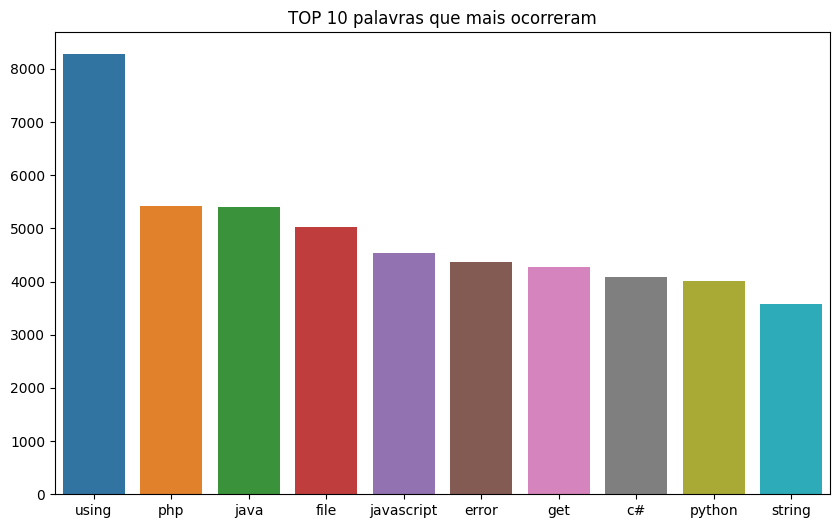

In [17]:
# Colocando as palavras em um objeto do tipo lista
words_list = list(dict(words_freq[:10]).keys())

# Colocando as ocorrências também em uma lista
occur_list = list(dict(words_freq[:10]).values())

# Preparando plotagem
plt.figure(figsize=(10,6))

ax = sns.barplot(x = words_list, y = occur_list)

ax.set_title("TOP 10 palavras que mais ocorreram")

#plt.xticks(rotation=30)

Realizando o mesmo processo para contar as Tags

In [18]:
# realizando a contagem e inserindo o valor em um dicionário
tags_count = Counter(chain.from_iterable([i for i in y_train]))

# Ordenando do maior para o menor
tags_freq = sorted(tags_count.items(), key=lambda x: x[1], reverse=True)

In [19]:
tags_freq[:10]

[('javascript', 19078),
 ('c#', 19077),
 ('java', 18661),
 ('php', 13907),
 ('python', 8940),
 ('jquery', 7510),
 ('c++', 6469),
 ('html', 4668),
 ('objective-c', 4338),
 ('asp.net', 3939)]

Text(0.5, 1.0, 'TOP 10 tags que mais ocorreram')

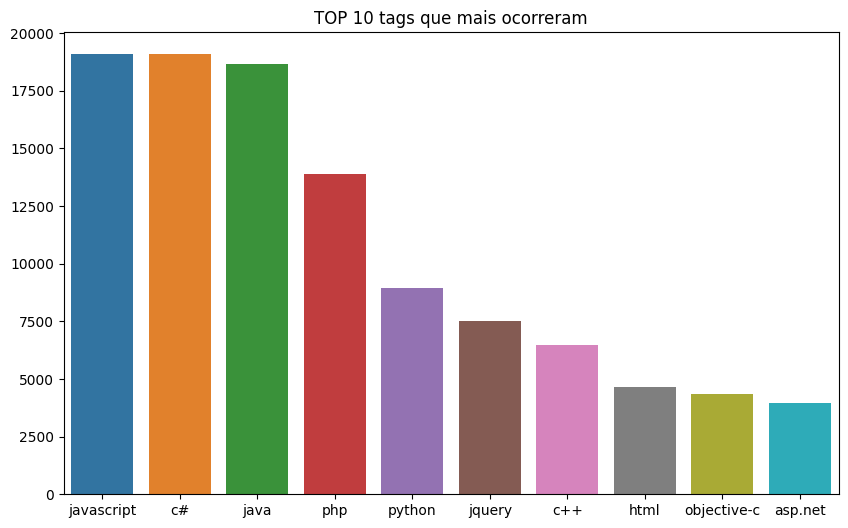

In [20]:
tags_list = list(dict(tags_freq[:10]).keys())

occur_tags_list = list(dict(tags_freq[:10]).values())

# Preparando plotagem
plt.figure(figsize=(10,6))

ax = sns.barplot(x = tags_list, y = occur_tags_list)

ax.set_title("TOP 10 tags que mais ocorreram")

#plt.xticks(rotation=30)

Transformando os textos em vetores numérico (Vetorização), visto que algoritmos de ML não trabalham com strings.

In [21]:
# Definição de um limite de palavras/features
max_features = 5000

# Instância do vetorizador
vectorizer = CountVectorizer(max_features = max_features)

# Aplicando a transformação (bow = bag of words)
X_train_bow = vectorizer.fit_transform(X_train)

X_val_bow = vectorizer.transform(X_val)

# Checando o shape
print(f'X_train shape: {X_train_bow.shape}')
print(f"X_val shape {X_val_bow.shape}")

X_train shape: (100000, 5000)
X_val shape (30000, 5000)


TF-IDF

capturando as frequencias relativas das palavras, pois ajuda a penalizar as palavras muito frequentes e otimiza o uso das melhores.

In [22]:
# Instanciando o tf-idf
tfidf_vectorizer = TfidfVectorizer(token_pattern='(\S+)', min_df=5, max_df=.9, ngram_range=(1,2))

# Aplicando o modelo com fit_transform nos dados de treino
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Aplicando o modelo com transform nos dados de validação
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# Coletando as palavras
tfidf_vocab = tfidf_vectorizer.vocabulary_

# Invertendo o dicionário para termos a quantidade como chaves
tfidf_reverse_vocab = {i:word for word, i in tfidf_vocab.items()}

convertendo a variável alvo em binário, ou seja, a previsão será 0 e 1

In [23]:
# Instanciando o MultilabelBinarizer
mlb = MultiLabelBinarizer(classes = sorted(tags_count.keys()))

# Convertendo rótulos de treino com fit_transform
y_train = mlb.fit_transform(y_train)

# Transformando dados de validação com fit_transform
y_val = mlb.fit_transform(y_val)

In [24]:
y_train[:3]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,

In [25]:
y_val[:3]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,

In [26]:
# Vendo as classes que foram binzarizadas
mlb.classes_

array(['.net', 'ajax', 'algorithm', 'android', 'angularjs', 'apache',
       'arrays', 'asp.net', 'asp.net-mvc', 'c', 'c#', 'c++', 'class',
       'cocoa-touch', 'codeigniter', 'css', 'csv', 'database', 'date',
       'datetime', 'django', 'dom', 'eclipse', 'entity-framework',
       'excel', 'facebook', 'file', 'forms', 'function', 'generics',
       'google-maps', 'hibernate', 'html', 'html5', 'image', 'ios',
       'iphone', 'java', 'javascript', 'jquery', 'json', 'jsp', 'laravel',
       'linq', 'linux', 'list', 'loops', 'maven', 'mongodb',
       'multithreading', 'mysql', 'node.js', 'numpy', 'objective-c',
       'oop', 'opencv', 'osx', 'pandas', 'parsing', 'performance', 'php',
       'pointers', 'python', 'python-2.7', 'python-3.x', 'qt', 'r',
       'regex', 'rest', 'ruby', 'ruby-on-rails', 'ruby-on-rails-3',
       'selenium', 'servlets', 'session', 'sockets', 'sorting', 'spring',
       'spring-mvc', 'sql', 'sql-server', 'string', 'swift', 'swing',
       'twitter-bootstrap'

Treinamento e Teste

In [27]:
def train_classifier(X_train, y_train, C=2.5, penalty='l2'):

  # Instanciando o modelo
  logreg = LogisticRegression(C=C, penalty=penalty, max_iter=2000)

  one_vs_rest = OneVsRestClassifier(logreg).fit(X_train, y_train)

  return one_vs_rest

**Aplicando a função**

In [28]:
# Treinando um classificador com bow
classif_bow = train_classifier(X_train_bow, y_train)

# Treinando um classificador com tf-idf
classif_tfidf = train_classifier(X_train_tfidf, y_train)

In [29]:
# Realizando as previsões com labels
y_val_predicted_labels_bow = classif_bow.predict(X_val_bow)

# Realizando as previsões com scores
y_val_predicted_scores_bow = classif_bow.decision_function(X_val_bow)

y_val_predicted_labels_tfidf = classif_tfidf.predict(X_val_tfidf)

y_val_predicted_scores_tfidf = classif_tfidf.decision_function(X_val_tfidf)

In [30]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(5):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	


Title:	contenttype applicationjson required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	ruby-on-rails


Title:	sessions sinatra used pass variable
True labels:	ruby,session
Predicted labels:	


Title:	getting error type json exist postgresql rake db migrate
True labels:	json,ruby,ruby-on-rails
Predicted labels:	json,ruby-on-rails




In [32]:
# Criando função para avaliação
def print_evaluation_scores (y_val, predicted):

  # Acurácia
  print(f"Accuracy Score: {accuracy_score(y_true=y_val, y_pred=predicted)}")

  # F1-Score
  print(f"F1-Score: {np.mean(np.array(f1_score(y_true=y_val, y_pred=predicted, average='micro')))}")

  # Precision
  print(f"Precision Score: {average_precision_score(y_true=y_val, y_score=predicted, average='weighted')}")

In [33]:
print('Bag-of-words')
print('---------------------------------------------')
print_evaluation_scores(y_val, y_val_predicted_labels_bow)
print('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')
print('\nTfidf')
print('---------------------------------------------')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)
print('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')

Bag-of-words
---------------------------------------------
Accuracy Score: 0.3269
F1-Score: 0.6471222201496404
Precision Score: 0.48119249356885613
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

Tfidf
---------------------------------------------
Accuracy Score: 0.35406666666666664
F1-Score: 0.6612793755832698
Precision Score: 0.501591463716413
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


Análise das variáveis mais importantes

In [41]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    print('Tag:\t{}'.format(tag))

    # Extract an estimator from the classifier for the given tag.
    # Extract feature coefficients from the estimator.

    est = classifier.estimators_[tags_classes.index(tag)]

    top_positive_words = [index_to_words[index] for index in est.coef_.argsort().tolist()[0][-5:]]# top-5 words sorted by the coefficiens.
    top_negative_words = [index_to_words[index] for index in est.coef_.argsort().tolist()[0][:5]]# bottom-5 words  sorted by the coefficients.
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [44]:
# cria a lista de palavras
lista_palavras = ['c', 'c++', 'linux']
all_words_text = list(words_count.keys())
for w in lista_palavras:
    print_words_for_tag(classif_tfidf, w, mlb.classes, tfidf_reverse_vocab, all_words_text)

Tag:	c
Top positive words:	printf, malloc, scanf, cc++, c
Top negative words:	java, php, python, javascript, c#

Tag:	c++
Top positive words:	mfc, boost, cc++, qt, c++
Top negative words:	java, php, javascript, python, c#

Tag:	linux
Top positive words:	unix, address, signal, ubuntu, linux
Top negative words:	javascript, c#, jquery, array, method

